<a href="https://colab.research.google.com/github/estebanbecerra/k_brazos_BCR/blob/main/MonteCarloTodasLasVisitas_Gymnasium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Monte Carlo con Políticas epsilon-soft**

_Esto es un ejemplo de uso de Gymnasium e informe sobre un experimento de aprendizaje por refuerzo_

````
Luis D. Hernández.
<ldaniel at um.es>
````

Este notebook describe un experimento de aprendizaje por refuerzo utilizando el algoritmo de Monte Carlo con políticas epsilon-soft. El propósito de este análisis es entrenar un agente en un entorno de gym con el juego "FrozenLake", un entorno estándar en el que el agente debe aprender a moverse a través de un mapa en busca de una meta, evitando caer en agujeros. A continuación, se presenta una descripción de las diferentes partes del código y el proceso utilizado en el experimento.

## **1. Preparación del Entorno**

La preparación consta de las siguientes partes:
- **Instalación de Dependencias**: Se instalan las librerías necesarias para utilizar el entorno `gymnasium` para la simulación, con el objetivo de crear un ambiente controlado para que el agente pueda interactuar.
- **Importación de Librerías**: Se importan las bibliotecas necesarias como `numpy` para el manejo de matrices y `matplotlib` para la visualización de los resultados.

- **Importación del Entorno "FrozenLake"**:
Se cargan dos versiones del entorno "FrozenLake": una de 4x4 y otra de 8x8. Ambas versiones no son resbaladizas, lo que facilita la comprensión de los resultados, dado que el entorno resbaladizo podría dificultar la comprensión inicial del aprendizaje.

#### 3. **Funciones para Mostrar los Resultados**
   - Se define una función para graficar la proporción de recompensas obtenidas en cada episodio del entrenamiento. Esto ayuda a visualizar el progreso del agente en términos de su desempeño durante el entrenamiento.



##### _________ **Código de la Instalación e Importación**
----

In [1]:
%%capture
#@title Instalamos gym
!pip install 'gym[box2d]==0.20.0'

## Instalación de algunos paquetes.
#!apt-get update
## Para usar gymnasium[box2d]
#!apt install swig
#!pip install gymnasium[box2d]

In [2]:
#@title Importamos librerias
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym

In [3]:
#@title Importamos el lago helado
name = 'FrozenLake-v1'
env4 = gym.make(name, is_slippery=False, map_name="4x4", render_mode="ansi") # No resbaladizo para entender mejor los resultados.
env8 = gym.make(name, is_slippery=False, map_name="8x8", render_mode="ansi") # No resbaladizo para entender mejor los resultados.

## **2. Diseño del Agente**

El diseño del agente consta de dos partes, el algoritmo con el que aprende y las políticas (toma de decisiones) que realiza.

- **Políticas del Agente**
   - **Política epsilon-soft**: Se define una política donde todas las acciones tienen una probabilidad de ser elegida.
   - **Política epsilon-greedy**: basada en la política epsilon-soft. De esta forma el agente tiene una pequeña probabilidad de explorar (tomar una acción aleatoria) y una mayor probabilidad de explotar (tomar la acción que considera mejor). Esto permite equilibrar la exploración y la explotación.
   - **Política greedy**: Es la usada una vez que "ha aprendido".

- **Algoritmo de Iteración de Valor**
  - Se implementa el algoritmo de iteración de valor utilizando Monte Carlo.
  - Se usa una versión "on-policy" de Monte Carlo con políticas epsilon greedy sobre una política epsilon-soft.
  - Se basa en el criterio de todas las visitas.
  - Otro aspecto es que la actualización de los retornos no se realiza en el orden inverso a las visitas.

#### **Código de las políticas y algoritmo MC**
----------------

In [4]:
# @title Políticas del agente

# actions
LEFT, DOWN, RIGHT, UP = 0,1,2,3

# Política epsilon-soft. Se usa para el entrenamiento
def random_epsilon_greedy_policy(Q, epsilon, state, nA):
    pi_A = np.ones(nA, dtype=float) * epsilon / nA
    best_action = np.argmax(Q[state])
    pi_A[best_action] += (1.0 - epsilon)
    return pi_A

# Política epsilon-greedy a partir de una epsilon-soft
def epsilon_greedy_policy(Q, epsilon, state, nA):
    pi_A = random_epsilon_greedy_policy(Q, epsilon, state, nA)
    return np.random.choice(np.arange(nA), p=pi_A)

# Política Greedy a partir de los valones Q. Se usa para mostrar la solución.
def pi_star_from_Q(env, Q):
    done = False
    pi_star = np.zeros([env.observation_space.n, env.action_space.n])
    state, info = env.reset() # start in top-left, = 0
    actions = ""
    while not done:
        action = np.argmax(Q[state, :])
        actions += f"{action}, "
        pi_star[state,action] = action
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    return pi_star, actions

In [5]:
#@title Algoritmo de Iteración de Valor versión MC con Políticas epsilon-soft

def on_policy_all_visit(env, num_episodes=5000, epsilon=0.4, decay=False, discount_factor=1):
    # Matriz de valores  Q
    nA = env.action_space.n
    Q = np.zeros([env.observation_space.n, nA])

    # Número de visitas para la versión incremental
    n_visits = np.zeros([env.observation_space.n, env.action_space.n])

    # Para mostrar la evolución en el terminal y algún dato que mostrar
    stats = 0.0
    list_stats = []            # guardará la media de recompensas hasta el episodio t
    episode_lengths = []       # <-- NUEVA lista para guardar longitudes de episodios

    step_display = num_episodes / 10 if num_episodes >= 10 else 1

    for t in tqdm(range(num_episodes)):
        state, info = env.reset(seed=100)
        done = False
        episode = []
        result_sum = 0.0  # Retorno
        factor = 1

        # Para medir longitud del episodio
        steps_in_episode = 0

        while not done:
            if decay:
                epsilon = min(1.0, 1000.0/(t+1))
            action = epsilon_greedy_policy(Q, epsilon, state, nA)
            new_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode.append((state, action))
            result_sum += factor * reward
            factor *= discount_factor
            state = new_state

            steps_in_episode += 1  # contamos un paso más

        # Una vez finalizado el episodio, actualizamos Q con "todas las visitas"
        for (s, a) in episode:
            n_visits[s, a] += 1.0
            alpha = 1.0 / n_visits[s, a]
            Q[s, a] += alpha * (result_sum - Q[s, a])

        # Guardamos datos sobre la evolución
        stats += result_sum
        promedio_recompensas = stats / (t + 1)
        list_stats.append(promedio_recompensas)

        # Guardamos la longitud del episodio
        episode_lengths.append(steps_in_episode)

        # Para mostrar la evolución en pantalla
        if (t+1) % step_display == 0 and t != 0:
            print(f"Episodio {t+1}/{num_episodes} -> Éxito promedio: {promedio_recompensas:.3f}, epsilon: {epsilon:.3f}")

    return Q, list_stats, episode_lengths



## **3. Experimentación**

   - En esta sección, el algoritmo de Monte Carlo con la política epsilon-soft se ejecuta tanto para el entorno de 4x4 como al de 8x8 de FrozenLake sin resbalar.
   
   - En ambos casos se realiza un entrenamiento con un número determinado de episodios (5000 en concreto)

   - Además en el escenario 8x8 el  epsilon tiene decaimiento de acuerdo a la expresión: $\epsilon = min(1.0, 1000.0/(t+1))$

   - Durante el entrenamiento hay una visualización de la proporción de recompensas obtenidas a lo largo del entrenamiento.

   - Junto a dicho volcado se muestra gráficamente la proporcion de recompensas obtendias.

   - También se hace un volcado de los valores Q de cada estado, donde se muestra cómo el agente valora diferentes acciones en distintos estados del entorno, lo que puede interpretarse como su conocimiento sobre las mejores estrategias para alcanzar la meta sin caer en los agujeros.

   - Además, se muestra la política óptima derivada de los valores Q. Esta política es la que el agente seguiría si tuviera que elegir siempre la acción que maximiza su recompensa esperada.

   

### **3.1 Repressentaciones Gráficas**

Para comprobar el aprendizaje se mostrará la función $f(t)=\frac{\sum_{i=1}^t R_i}{t}$ para $t=1,2,\ldots, NumeroEpisodios$. La justificación es la siguiente. Como sabemmos que el retorno en el estados inicial 1 (pues no hay descuento) o 9, si se divide por el número de episodios ejecutados se calcular el porcentaje de recompensas positivas obtenidas. Dicho de otra forma, nos dirá el porcentaje de veces que el agente ha llegado al estado terminal.

*TODO:* Contruir una gráfica que muestre la longitud de los episodios en cada estado junto con la curva de tendencia.

In [6]:
# @title Funciones para mostrar los resultados

def plot(list_stats):
  # Creamos una lista de índices para el eje x
  indices = list(range(len(list_stats)))

  # Creamos el gráfico
  plt.figure(figsize=(6, 3))
  plt.plot(indices, list_stats)

  # Añadimos título y etiquetas
  plt.title('Proporción de recompensas')
  plt.xlabel('Episodio')
  plt.ylabel('Proporción')

  # Mostramos el gráfico
  plt.grid(True)
  plt.show()

# Define la función para mostrar el tamaño de los episodios
# Pon aquí tu código.

In [7]:
def plot_episode_lengths(episode_lengths):
    """
    Muestra la longitud de cada episodio a lo largo del entrenamiento.
    """
    plt.figure(figsize=(6, 3))
    plt.plot(episode_lengths, label="Longitud del episodio")
    plt.xlabel("Episodio")
    plt.ylabel("Longitud")
    plt.title("Evolución de la longitud de los episodios")
    plt.grid(True)
    plt.legend()
    plt.show()


### **3.2 Experimentación en el escenario 4x4**



   - Se realizan 5000 epsisodios y se actualizan los valores Q (valor de acción) basándose en las recompensas obtenidas durante cada episodio completo (e.d. aplicamos Monte Carlo) Se apica una política $\epsilon$ greedy sobre una política $\epsilon$ soft con un valor $\epsilon$ constante




In [9]:
# @title Aprendizaje
Q, list_stats, episode_lengths = on_policy_all_visit(env4, num_episodes=50000, epsilon=0.4, discount_factor=1)

 10%|█         | 5241/50000 [00:03<00:31, 1405.84it/s]

Episodio 5000/50000 -> Éxito promedio: 0.460, epsilon: 0.400


 21%|██        | 10354/50000 [00:07<00:21, 1833.47it/s]

Episodio 10000/50000 -> Éxito promedio: 0.501, epsilon: 0.400


 30%|███       | 15218/50000 [00:09<00:18, 1837.41it/s]

Episodio 15000/50000 -> Éxito promedio: 0.512, epsilon: 0.400


 40%|████      | 20225/50000 [00:12<00:15, 1924.82it/s]

Episodio 20000/50000 -> Éxito promedio: 0.520, epsilon: 0.400


 51%|█████     | 25354/50000 [00:14<00:12, 1908.19it/s]

Episodio 25000/50000 -> Éxito promedio: 0.524, epsilon: 0.400


 60%|██████    | 30180/50000 [00:18<00:16, 1215.69it/s]

Episodio 30000/50000 -> Éxito promedio: 0.526, epsilon: 0.400


 71%|███████   | 35268/50000 [00:20<00:07, 1966.52it/s]

Episodio 35000/50000 -> Éxito promedio: 0.529, epsilon: 0.400


 81%|████████  | 40388/50000 [00:23<00:04, 1959.27it/s]

Episodio 40000/50000 -> Éxito promedio: 0.530, epsilon: 0.400


 91%|█████████ | 45379/50000 [00:26<00:02, 1785.47it/s]

Episodio 45000/50000 -> Éxito promedio: 0.530, epsilon: 0.400


100%|██████████| 50000/50000 [00:28<00:00, 1727.06it/s]

Episodio 50000/50000 -> Éxito promedio: 0.532, epsilon: 0.400


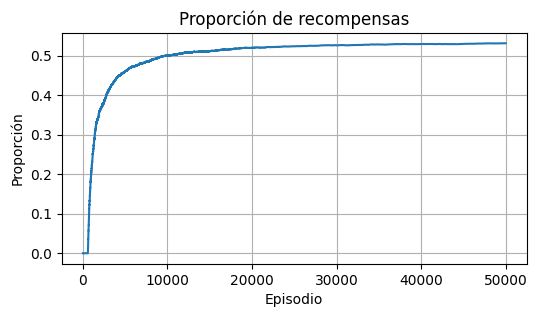

Máxima proporcion: 0.53172


In [10]:
#@title Proporción de aciertos por número de episodios

plot(list_stats)
print(f"Máxima proporcion: {list_stats[-1]}")

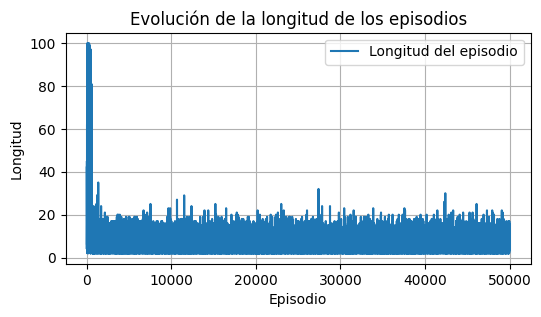

In [11]:
# Gráfica de la longitud de los episodios
plot_episode_lengths(episode_lengths)

####.
Mostramos los valores Q para cada estado. Cada estado tienen 4 valores, que se corresponden con las 4 acciones que se pueden en cada estado.

In [12]:
# @title Tabla de valores Q
LEFT, DOWN, RIGHT, UP = 0,1,2,3
print("Valores Q para cada estado:\n", Q)


Valores Q para cada estado:
 [[0.30456247 0.53187028 0.46839959 0.47376484]
 [0.29689441 0.         0.59554761 0.44724221]
 [0.49054622 0.62810626 0.55393939 0.59452736]
 [0.63737796 0.         0.4609375  0.54368932]
 [0.39465174 0.61549163 0.         0.51400981]
 [0.         0.         0.         0.        ]
 [0.         0.80674549 0.         0.63022942]
 [0.         0.         0.         0.        ]
 [0.52891883 0.         0.71713292 0.53172738]
 [0.60172283 0.82284218 0.80617472 0.        ]
 [0.72535648 0.96246484 0.         0.62033462]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.8325723  0.95941573 0.71684146]
 [0.82679401 0.95780151 1.         0.81914331]
 [0.         0.         0.         0.        ]]


- También se muestra la política óptima (greedy) obtenida a partir del aprendizaje anterior.

- Cada estado tienen 4 valores, pero todos son 0 menos 1. Es decir, en cada estado se aplica de manera determinística una única acción.

*TODO:* Mostrar de forma gráfica el escenario.

In [13]:
# @title Política final
LEFT, DOWN, RIGHT, UP = 0,1,2,3
pi, actions = pi_star_from_Q(env4, Q)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env4.render())
print()

Política óptima obtenida
 [[0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 0.]] 
 Acciones 1, 1, 2, 1, 2, 2,  
 Para el siguiente grid
   (Right)
SFFF
FHFH
FFFH
HFFG




### **3.3 Experimentación en el escenario 8x8**

  - Se realizan 5000 epsisodios y se actualizan los valores Q (valor de acción) basándose en las recompensas obtenidas durante cada episodio completo (e.d. aplicamos Monte Carlo) Se apica una política $\epsilon$ greedy sobre una política $\epsilon$ soft con un valor $\epsilon$ decreciente



In [15]:
# @title Aprendizaje
Q, list_stats, episode_lengths = on_policy_all_visit(env8, num_episodes=50000, epsilon=0.4, decay=True, discount_factor=1)

 10%|█         | 5038/50000 [00:18<03:00, 248.85it/s]

Episodio 5000/50000 -> Éxito promedio: 0.303, epsilon: 0.200


 20%|██        | 10043/50000 [00:39<02:29, 268.12it/s]

Episodio 10000/50000 -> Éxito promedio: 0.503, epsilon: 0.100


 30%|███       | 15118/50000 [00:57<00:48, 726.60it/s]

Episodio 15000/50000 -> Éxito promedio: 0.611, epsilon: 0.067


 40%|████      | 20141/50000 [01:05<00:41, 723.71it/s]

Episodio 20000/50000 -> Éxito promedio: 0.693, epsilon: 0.050


 50%|█████     | 25090/50000 [01:12<00:33, 734.82it/s]

Episodio 25000/50000 -> Éxito promedio: 0.745, epsilon: 0.040


 60%|██████    | 30108/50000 [01:19<00:27, 732.56it/s]

Episodio 30000/50000 -> Éxito promedio: 0.781, epsilon: 0.033


 70%|███████   | 35127/50000 [01:26<00:21, 705.22it/s]

Episodio 35000/50000 -> Éxito promedio: 0.808, epsilon: 0.029


 80%|████████  | 40085/50000 [01:34<00:12, 769.36it/s]

Episodio 40000/50000 -> Éxito promedio: 0.829, epsilon: 0.025


 90%|█████████ | 45111/50000 [01:41<00:08, 545.89it/s]

Episodio 45000/50000 -> Éxito promedio: 0.845, epsilon: 0.022


100%|██████████| 50000/50000 [01:48<00:00, 462.05it/s]

Episodio 50000/50000 -> Éxito promedio: 0.859, epsilon: 0.020


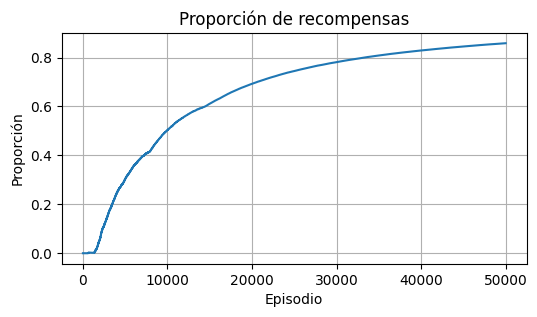

Máxima proporcion: 0.85852


In [20]:
#@title Proporción de aciertos por número de episodios

plot(list_stats)
print(f"Máxima proporcion: {list_stats[-1]}")

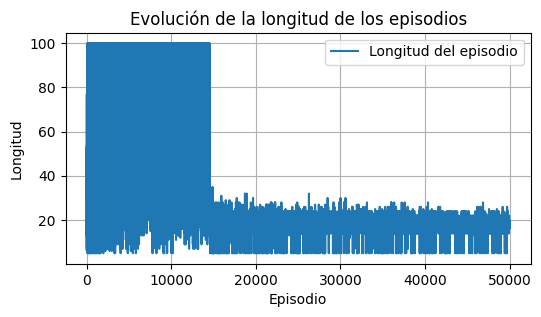

In [21]:
# Gráfica de la longitud de los episodios
plot_episode_lengths(episode_lengths)

####.
Mostramos los valores Q para cada estado. Cada estado tienen 4 valores, que se corresponden con las 4 acciones que se pueden en cada estado.

In [22]:
# @title Tabla de valores Q
LEFT, DOWN, RIGHT, UP = 0,1,2,3
print("Valores Q para cada estado:\n", Q)

Valores Q para cada estado:
 [[0.29906047 0.56226622 0.36457526 0.30794702]
 [0.37897674 0.60576729 0.58400292 0.4298859 ]
 [0.11995754 0.16571429 0.65892729 0.15673981]
 [0.23789174 0.70591323 0.2652439  0.2454418 ]
 [0.1015873  0.12195122 0.62974684 0.15680473]
 [0.2615894  0.27899687 0.75451689 0.30797101]
 [0.65934066 0.66512059 0.93720168 0.7320197 ]
 [0.70957096 0.93764846 0.70575461 0.71412924]
 [0.33516166 0.32044924 0.84742194 0.36439389]
 [0.43627875 0.53288779 0.91744286 0.61223392]
 [0.40329218 0.43133951 0.91656944 0.45860927]
 [0.53621982 0.         0.92723542 0.56167763]
 [0.63809524 0.59067358 0.93491976 0.6460084 ]
 [0.68998794 0.69621749 0.93831124 0.6986755 ]
 [0.70601852 0.67295597 0.70802139 0.93863168]
 [0.73908413 0.93894426 0.73264249 0.70675105]
 [0.10658579 0.13164778 0.14551607 0.33227896]
 [0.14221422 0.15990058 0.45885167 0.1815154 ]
 [0.23799637 0.17847769 0.         0.75820142]
 [0.         0.         0.         0.        ]
 [0.         0.14516129 0.73286

- También se muestra la política óptima (greedy) obtenida a partir del aprendizaje anterior.

- Cada estado tienen 4 valores, pero todos son 0 menos 1. Es decir, en cada estado se aplica de manera determinística una única acción.

*TODO:* Mostrar de forma gráfica el escenario.

In [23]:
# @title Política final
LEFT, DOWN, RIGHT, UP = 0,1,2,3
pi, actions = pi_star_from_Q(env8, Q)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env8.render())
print()

Política óptima obtenida
 [[0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 3.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 
 Acciones 1,

## **4. Análisis y Estudios Futuros**

### **4.1 Análisis de Resultados**

- En los dos entornos (4x4 y 8x8), el agente comienza con un conocimiento muy limitado, pero gradualmente mejora su desempeño a medida que avanza en los episodios. Este comportamiento se puede observar en el gráfico de la proporción de recompensas, que aumenta con el tiempo.
- En el entorno 4x4, la máxima proporción de éxito alcanzada fue 0.522, mientras que en el entorno 8x8, la máxima alcanzada fue 0.914. Esto refleja que el agente aprendió a optimizar su estrategia en un entorno más complejo.
- La política óptima obtenida muestra las acciones recomendadas por el agente en cada estado del entorno. En el entorno 8x8, la política es más compleja debido a la mayor cantidad de estados y la dificultad del entorno.

### **4.2 Propuestas para Estudios Futuros**

1. **Evaluar con Otros Entornos**: Sería interesante aplicar este algoritmo a otros entornos más complejos de `gym`, como "Taxi-v3" o "MountainCar", para analizar cómo se comporta el agente en situaciones con dinámicas más complicadas.
   
2. **Optimización del Decaimiento de Epsilon**: Aunque se utilizó un decaimiento de epsilon en el segundo experimento, se podría investigar la efectividad de diferentes tasas de decaimiento o incluso explorar algoritmos como `Q-learning` para comparar su desempeño. Graficamente se trataría de mostrar la curva de la tasa de aciertos para distintas funciones de decaimientos

3. **Análisis del Impacto de los descuentos en las Recompensas**: El estudio se ha hecho para $\gamma = 1$; pero no se ha probado qué pasa cuando  $0 \leq \gamma < 1$. Se trataría de estudiar la curva para distintos valores de $\gamma$

4. **Nuevas gráficas**: Aquí solo se ha usado la proporción de aciertos, pero sería interesante qué relación entre dicha tasa y las tamaños de los episodios.

4. **Ampliación del Algoritmo**: Explorar otros enfoques de Monte Carlo o incluso combinar Monte Carlo con otros algoritmos de aprendizaje por refuerzo, como el Deep Q-Network (DQN), podría mejorar aún más los resultados en entornos más complejos.
